In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np

from numpy import genfromtxt
from scipy import stats

In [16]:
# this is z-score that value minus mean divided by standard deviation
# http://duramecho.com/Misc/WhyMinusOneInSd.html
def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

def append_bias_reshape(features,labels):
    n_training_samples = features.shape[0]
    n_dim = features.shape[1]
    # 아래꺼 np.c_만 하면 되는거 아닌가? reshape는 왜하지
    f = np.reshape(np.c_[np.ones(n_training_samples),features],[n_training_samples,n_dim + 1])
    l = np.reshape(labels,[n_training_samples,1])
    return f, l

In [17]:
# genfromtxt가 왜 tuple의 1 d array로만 나오는가?
# https://stackoverflow.com/questions/9534408/numpy-genfromtxt-produces-array-of-what-looks-like-tuples-not-a-2d-array-why
def read_dataset():
    xy = genfromtxt('winequality-red.csv', delimiter=';', skip_header=1, dtype=None)
    print xy, xy.shape
    x_data = np.array(xy[:, 0:-1])
    y_data = np.array(xy[:, [-1]])
    return x_data, y_data

# np.loadtxt를 쓰자
def read_red_wine_data():
    xy = np.loadtxt('winequality-red.csv', delimiter=';', skiprows=1)
    x_data = xy[:, 0:-1]
    y_data = xy[:, [-1]]
    return x_data, y_data

In [18]:
features, labels = read_red_wine_data()
print features.shape, labels.shape
print stats.describe(features).variance

(1599, 11) (1599, 1)
[  3.03141639e+00   3.20623777e-02   3.79474831e-02   1.98789713e+00
   2.21514265e-03   1.09414884e+02   1.08210237e+03   3.56202945e-06
   2.38351805e-02   2.87326161e-02   1.13564740e+00]


In [19]:
normalized_features = feature_normalize(features)
print stats.describe(normalized_features).variance

[ 1.00062578  1.00062578  1.00062578  1.00062578  1.00062578  1.00062578
  1.00062578  1.00062578  1.00062578  1.00062578  1.00062578]


In [20]:
# f, l = append_bias_reshape(normalized_features,labels)
n_dim = features.shape[1]

In [21]:
# rand는 [0,1)의 array를 만들어냄 따라서 0.8보다 작은 행을 true로 만들어 train data set으로 선택하려는 것
# 80%를 의미하는 지는 rand 내부를 봐야함
rnd_indices = np.random.rand(len(features)) < 0.80

train_x = normalized_features[rnd_indices]
train_y = labels[rnd_indices]
test_x = normalized_features[~rnd_indices]
test_y = labels[~rnd_indices]

In [22]:
training_epochs = 10000
learning_rate = 0.01
cost_history = np.empty(shape=[1],dtype=float)
nb_classes = 11  # 0 ~ 10

X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.int32,[None,1])
Y_one_hot = tf.one_hot(Y, nb_classes)  # one hot
print("one_hot", Y_one_hot)
Y_one_hot = tf.reshape(Y_one_hot, [-1, nb_classes])
print("reshape", Y_one_hot)

('one_hot', <tf.Tensor 'one_hot_1:0' shape=(?, 1, 11) dtype=float32>)
('reshape', <tf.Tensor 'Reshape_4:0' shape=(?, 11) dtype=float32>)


In [23]:
# W = tf.Variable(tf.ones([n_dim,1]))
W = tf.Variable(tf.random_normal([n_dim, nb_classes]), name='weight')
b = tf.Variable(tf.random_normal([nb_classes]), name='bias')

#init = tf.global_variables_initializer()

In [24]:
# y_ = tf.matmul(X, W)
# cost = tf.reduce_mean(tf.square(y_ - Y))

# training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# tf.nn.softmax computes softmax activations
# softmax = exp(logits) / reduce_sum(exp(logits), dim)
logits = tf.matmul(X, W) + b
hypothesis = tf.nn.softmax(logits)

# Cross entropy cost/loss
# logits에는 hypothesis랑 logits 중 어느걸 넣어야되고 차이는 뭘까?
cost_i = tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis,
                                                 labels=Y_one_hot)

cost = tf.reduce_mean(cost_i)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [25]:
prediction = tf.argmax(hypothesis, 1)
correct_prediction = tf.equal(prediction, tf.argmax(Y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [26]:
# sess = tf.Session()
# sess.run(init)

# for epoch in range(training_epochs):
#     sess.run(training_step,feed_dict={X:train_x,Y:train_y})
#     cost_history = np.append(cost_history,sess.run(cost,feed_dict={X: train_x,Y: train_y}))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for step in range(training_epochs + 1):
        sess.run(optimizer, feed_dict={X: train_x, Y: train_y})
        loss, acc = sess.run([cost, accuracy], feed_dict={
                                 X: train_x, Y: train_y})
        cost_history = np.append(cost_history, acc)
        if step % 1000 == 0:
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(
                step, loss, acc))
            
    # Test model and check accuracy
    correct_prediction = tf.equal(tf.argmax(hypothesis, 1), train_y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print('Accuracy:', sess.run(accuracy, feed_dict={X: train_x}))
    
    col_desc = [
    "1 - fixed acidity",
    "2 - volatile acidity",
    "3 - citric acid",
    "4 - residual sugar",
    "5 - chlorides",
    "6 - free sulfur dioxide",
    "7 - total sulfur dioxide",
    "8 - density",
    "9 - pH",
    "10 - sulphates",
    "11 - alcohol"]

    print np.c_[sess.run(W), col_desc]

Step:     0	Loss: 2.439	Acc: 6.39%
Step:  1000	Loss: 1.920	Acc: 63.93%
Step:  2000	Loss: 1.909	Acc: 64.40%
Step:  3000	Loss: 1.904	Acc: 64.64%
Step:  4000	Loss: 1.901	Acc: 64.88%
Step:  5000	Loss: 1.895	Acc: 65.51%
Step:  6000	Loss: 1.892	Acc: 65.75%
Step:  7000	Loss: 1.891	Acc: 65.90%
Step:  8000	Loss: 1.889	Acc: 65.90%
Step:  9000	Loss: 1.888	Acc: 65.98%
Step: 10000	Loss: 1.887	Acc: 65.98%
('Accuracy:', 0.37168571)
[['1.20671248436' '1.22706711292' '0.987164080143' '1.8101348877'
  '-23.9491405487' '-13.9522438049' '9.9496307373' '29.1473770142'
  '0.655552625656' '1.20251882076' '0.22347278893' '1 - fixed acidity']
 ['-1.90141379833' '-1.66354858875' '-1.81717050076' '-1.08203494549'
  '18.5013256073' '15.723938942' '-16.2419548035' '-27.8620700836'
  '-0.628006577492' '-1.09566819668' '-0.378148019314'
  '2 - volatile acidity']
 ['0.11244533211' '0.470645219088' '0.234025537968' '0.591533184052'
  '4.1648812294' '11.708325386' '-12.3225345612' '-8.24929523468'
  '0.730527698994' '0

(10002,)


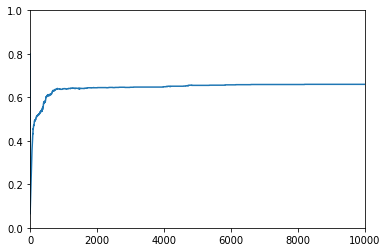

In [27]:
print cost_history.shape
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,1])
plt.show()

In [28]:
sess.close()